※ Global variables

In [106]:
import torch
import numpy as np
gnDataset = 1
gBase_path = 'C:/Users/AdamBao/PycharmProjects/Tool_Classifier/Model'
gnClasses = 5

gDropout_rate = 0.3
gBatch_momentum = 0.1
gLearning_rate = 0.00001
gWeight_decay = 1e-3
gOpt_Momentum = 0.9

gData_batch_size = 64
gEarly_stop_patience = 30
gnEpochs = 200
gbData_augmentation = True

gModel_name = ["cnn", "resnet", "mobilenet_v2","efficientnet_b0"] # 
gOptimizer_name = "Adam" # , "SGD"
gCriterion_name = "CrossEntropyLoss"


import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


    ※ Widget functions

In [144]:
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
from torchvision.transforms.functional import to_pil_image

class ToolDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]

        # If the data is already a tensor, convert it back to PIL
        if isinstance(img, torch.Tensor):
            img = to_pil_image(img)  # Convert tensor to PIL image

        # Apply transformations
        if self.transform:
            img = self.transform(img)

        # Ensure the output is a tensor
        if not isinstance(img, torch.Tensor):
            img = F.to_tensor(img)  # Convert back to tensor if transform outputs a PIL image

        return img, label

def _load_data(train_data_path):
    raw_data = torch.load(train_data_path)
    data = raw_data['data']
    labels = raw_data['labels']
    return data, labels

def remap_labels(labels, class_mapping):
    return [class_mapping[label] for label in labels]

def load_class_names(filepath):
    with open(filepath, 'r') as file:
        classes = [line.strip() for line in file]
    return classes

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_layers(model):
    layer_count = 0
    for module in model.children():
        if not isinstance(module, nn.Dropout):  # deduct Dropout
            layer_count += 1
    return layer_count


class ToolPlot():
    def __init__(self, model, criterion, device, train_dataloader, test_dataloader, model_num):
        self.model = model
        self.criterion = criterion 
        self.device = device
        self.train_losses = []
        self.validation_losses = []
        self.validation_accuracies = []
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.running_loss = 0.0
        self.model_num = model_num + 1
    
    def init_running_loss(self):
        self.running_loss = 0.0

    def add_loss(self, loss):
        self.running_loss += loss

    def append(self, epoch):
        train_loss = self.running_loss / len(self.train_dataloader)
        validation_loss, validation_accuracy = self._validate()
        self.train_losses.append(train_loss)
        self.validation_losses.append(validation_loss)
        self.validation_accuracies.append(validation_accuracy)
        self._print(epoch, train_loss, validation_loss, validation_accuracy)
        return validation_loss

    def plot(self):
        self._plot_metrics(self.train_losses, self.validation_losses, self.validation_accuracies, self.model_num)
    
    def _print(self, epoch, train_loss, validation_loss, validation_accuracy):
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

    def _validate(self):
        self.model.eval()  # evaluation mode
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        with torch.no_grad():  # disable gradient calculations
            for inputs, labels in self.test_dataloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()
        
        validation_loss = running_loss / len(self.test_dataloader)
        validation_accuracy = correct_predictions / total_samples
        return validation_loss, validation_accuracy

    def _plot_metrics(self, train_losses, validation_losses, validation_accuracies, model_num):
        epochs = range(1, len(train_losses) + 1)

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss', marker='o')
        plt.plot(epochs, validation_losses, label='Validation Loss', marker='o')
        plt.title(f'Model {model_num} Learning per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(epochs, validation_accuracies, label='Validation Accuracy', marker='o', color='green')
        plt.title(f'Model {model_num} Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()    


class EarlyStopping():
    def __init__(self):
        self.best_val_loss = float('inf')
        self.patience_counter = 0

    def isStop(self, validation_loss):
        if validation_loss < self.best_val_loss: #
            self.best_val_loss = validation_loss
            self.patience_counter = 0
        else:
            self.patience_counter += 1
        
        if self.patience_counter >= gEarly_stop_patience: #
            print("Early stopping")
            return True
        else:
            return False


def get_data_augmentation(mode, mean, std):
    if gbData_augmentation == False:
        print("no agumentation")
        return None
    
    if mode == "train":
        return transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5)], p=0.3),
        transforms.RandomApply([transforms.RandomRotation(degrees=15)], p=0.3),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Random color adjustment
        transforms.RandomCrop(64, padding=4),  # Crop with padding
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
        ])
    else:
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

def compute_mean_std(data):
    print(f"Min pixel value: {data.min()}")  # Expected: 0 or near 0
    print(f"Max pixel value: {data.max()}")  # Expected: 255 or 1    
    # Convert NumPy array to PyTorch tensor if necessary
    if isinstance(data, np.ndarray):
        data = torch.from_numpy(data).float()
    
    # Ensure data is in (N, C, H, W) format
    if data.ndim == 4 and data.shape[3] in {1, 3}:  # (N, H, W, C)
        data = data.permute(0, 3, 1, 2)
    elif data.ndim == 3:  # Grayscale (N, H, W)
        data = data.unsqueeze(1)  # Convert to (N, 1, H, W)
    
    # Check and normalize pixel value range
    print(f"Min pixel value: {data.min().item()}")
    print(f"Max pixel value: {data.max().item()}")
    if data.max() > 1.0:  # Normalize if in [0, 255]
        print("Normalizing data to [0, 1].")
        data = data / 255.0

    # Compute mean and std for each channel
    mean = data.mean(dim=(0, 2, 3))  # Mean over (N, H, W)
    std = data.std(dim=(0, 2, 3))    # Std over (N, H, W)

    # Round to 3 decimal places
    mean_rounded = [round(m.item(), 3) for m in mean]
    std_rounded = [round(s.item(), 3) for s in std]

    return mean_rounded, std_rounded
    

def load_data(train_data_path, test_data_path):
    train_data, train_labels = _load_data(train_data_path)
    unique_labels = sorted({int(label) for label in train_labels})
    class_mapping = {label: i for i, label in enumerate(unique_labels)}
    print(class_mapping)
    if train_data_path == None:
        train_dataloader = None
        mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    else:
        # Compute mean and std from training data
        mean, std = compute_mean_std(train_data)
        print(f"Computed Mean: {mean}, Computed Std: {std}")
        train_remapped_labels = remap_labels(train_labels, class_mapping)
        transform = get_data_augmentation("train",mean, std)
        train_dataset = ToolDataset(train_data, train_remapped_labels, transform=transform)
        train_dataloader = DataLoader(train_dataset, batch_size=gData_batch_size, shuffle=True)
    if test_data_path == None:
        test_dataloader = None
    else:
        test_data, test_labels = _load_data(test_data_path)
        remapped_test_labels = remap_labels(test_labels, class_mapping)
        transform = get_data_augmentation("test",mean, std)
        test_dataset = ToolDataset(test_data, remapped_test_labels, transform=transform)
        test_dataloader = DataLoader(test_dataset, batch_size=gData_batch_size, shuffle=False)

    return train_dataloader, test_dataloader

In [145]:
mean = [0.6, 0.57, 0.541]
std = [0.312, 0.317, 0.332]
dummy_input = torch.rand(1, 3, 64, 64)  # 形状 [B, C, H, W]
normalized = transforms.Normalize(mean=mean, std=std)(dummy_input)
print("Dummy normalized range:", normalized.min().item(), normalized.max().item()) 

train_data_path = f"{gBase_path}/train_data.pth"
test_data_path = f"{gBase_path}/test_data.pth"
train_dataloader, test_dataloader = load_data(train_data_path, test_data_path)
def check_normalization(dataloader, n_batches=3):
    for batch_idx, (images, labels) in enumerate(dataloader):
        if batch_idx >= n_batches:  # 仅检查前n个批次
            break
        
        print(f"\nBatch {batch_idx}:")
        print(f"  - Shape: {images.shape}")  # 应为 [B, C, H, W]
        print(f"  - Min: {images.min().item():.4f}")
        print(f"  - Max: {images.max().item():.4f}")
        print(f"  - Mean: {images.mean().item():.4f}")
        print(f"  - Std: {images.std().item():.4f}")

# 检查训练集和测试集
print("=== Training Data ===")
check_normalization(train_dataloader)

print("\n=== Test Data ===")
check_normalization(test_dataloader)

Dummy normalized range: -1.922541856765747 1.381015658378601
{172: 0, 684: 1, 789: 2, 823: 3, 938: 4}
Min pixel value: 0.0
Max pixel value: 1.0
Min pixel value: 0.0
Max pixel value: 1.0
Computed Mean: [0.6, 0.57, 0.541], Computed Std: [0.312, 0.317, 0.332]
=== Training Data ===

Batch 0:
  - Shape: torch.Size([64, 3, 64, 64])
  - Min: -1.9231
  - Max: 1.3825
  - Mean: -0.3338
  - Std: 0.9841

Batch 1:
  - Shape: torch.Size([64, 3, 64, 64])
  - Min: -1.9231
  - Max: 1.3825
  - Mean: -0.3139
  - Std: 1.0199

Batch 2:
  - Shape: torch.Size([64, 3, 64, 64])
  - Min: -1.9231
  - Max: 1.3825
  - Mean: -0.1888
  - Std: 0.9792

=== Test Data ===

Batch 0:
  - Shape: torch.Size([64, 3, 64, 64])
  - Min: -1.9231
  - Max: 1.3825
  - Mean: 0.1270
  - Std: 1.0184

Batch 1:
  - Shape: torch.Size([64, 3, 64, 64])
  - Min: -1.9231
  - Max: 1.3825
  - Mean: -0.0667
  - Std: 1.0487

Batch 2:
  - Shape: torch.Size([64, 3, 64, 64])
  - Min: -1.9231
  - Max: 1.3825
  - Mean: 0.0273
  - Std: 1.0352


※ Datasets

{172: 0, 684: 1, 789: 2, 823: 3, 938: 4}
Min pixel value: 0.0
Max pixel value: 1.0
Min pixel value: 0.0
Max pixel value: 1.0
Computed Mean: [0.6, 0.57, 0.541], Computed Std: [0.312, 0.317, 0.332]


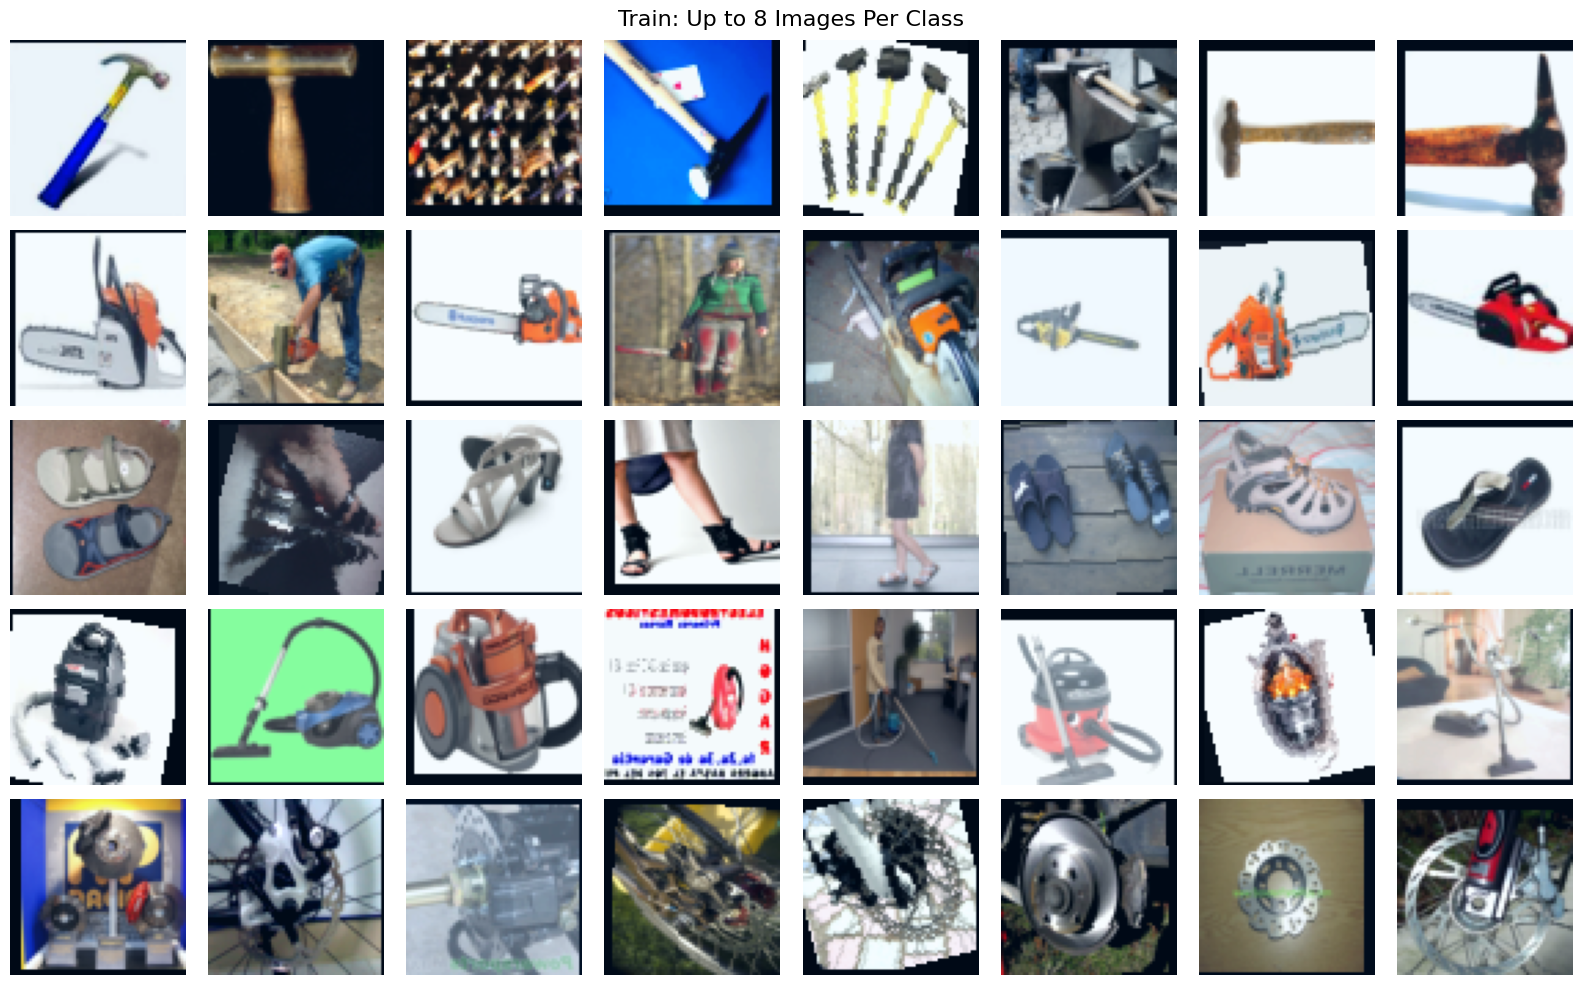

Class counts in Train dataset:


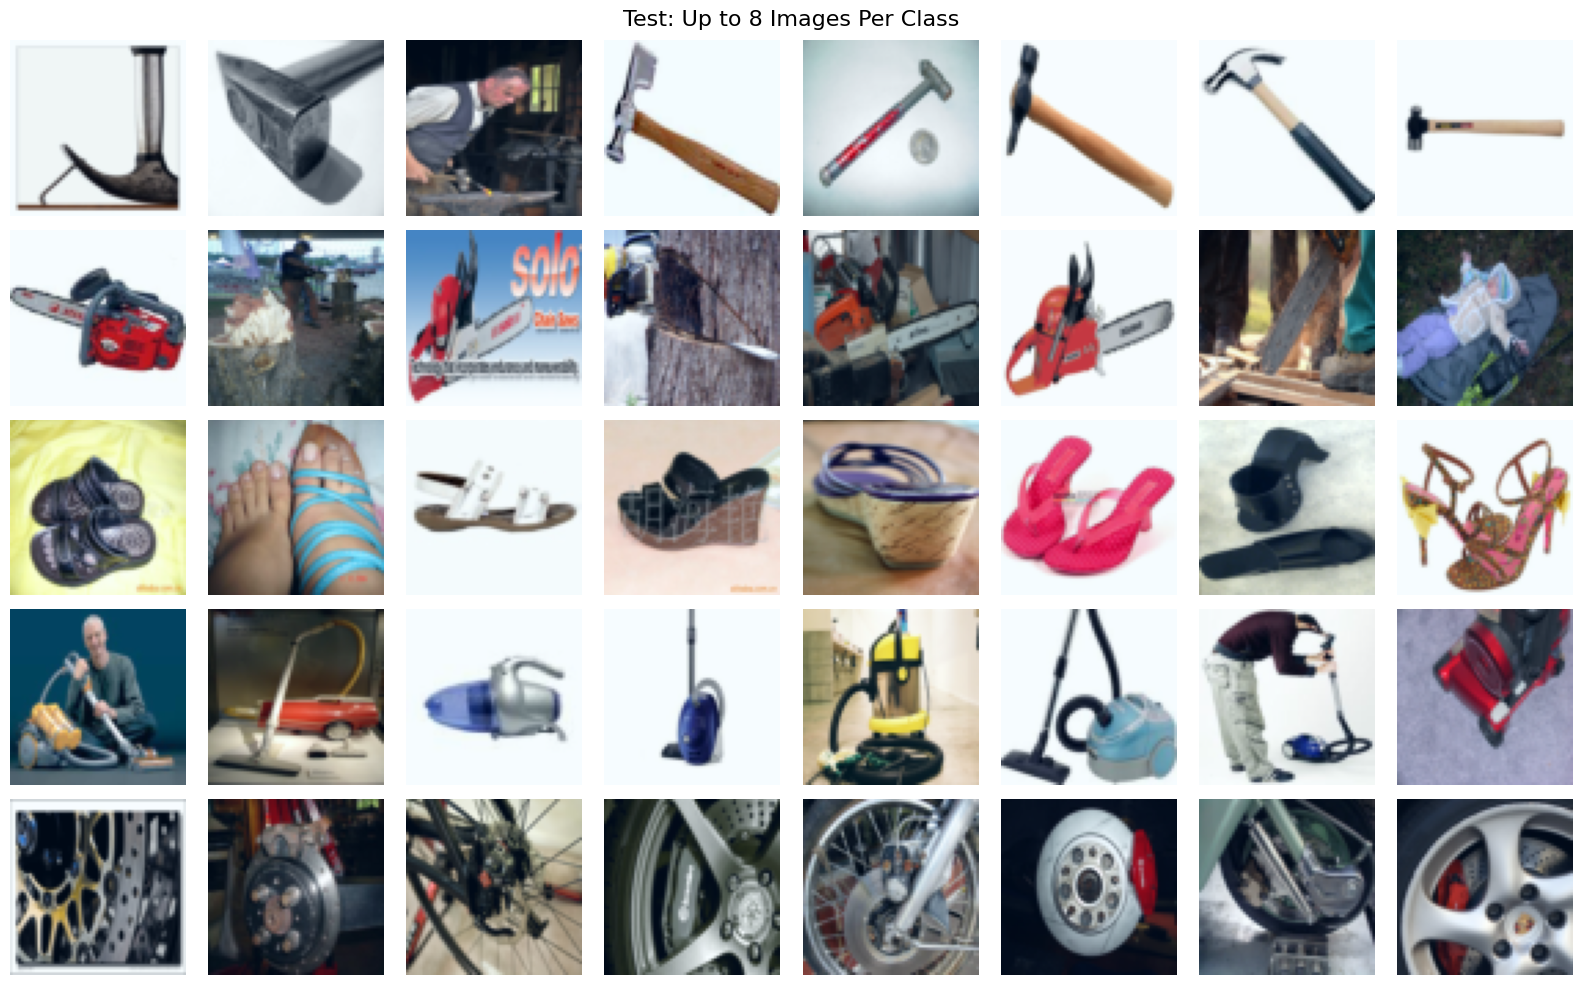

Class counts in Test dataset:
Class counts in Train dataset:
Dataset Train Class 0: 1258 images
Dataset Train Class 1: 1360 images
Dataset Train Class 2: 1240 images
Dataset Train Class 3: 1482 images
Dataset Train Class 4: 1037 images
Class counts in Test dataset:
Dataset Test Class 0: 132 images
Dataset Test Class 1: 159 images
Dataset Test Class 2: 142 images
Dataset Test Class 3: 162 images
Dataset Test Class 4: 114 images
全局标准化范围 - Min: -1.9231, Max: 1.3825


In [146]:
import torch
import matplotlib.pyplot as plt


def count_classes(dataloader, dataset_name="Dataset", num_classes=5 ):
    class_counts = {i: 0 for i in range(num_classes)}
    for batch in dataloader:
        inputs, labels = batch[0], batch[1]  # Unpack inputs and labels
        for label in labels:
            label = label.item()
            class_counts[label] += 1        
    print(f"Class counts in {dataset_name} dataset:")
    for cls, count in class_counts.items():
        print(f"Dataset {dataset_name} Class {cls}: {count} images")

def display_images_with_labels(dataloader, num_classes=5, dataset_name="Dataset", num_images=8):
    # Dictionary to store images grouped by class
    class_images = {i: [] for i in range(num_classes)}

    # Iterate through the dataloader to collect images
    for batch in dataloader:
        inputs, labels = batch[0], batch[1]  # Unpack inputs and labels
        inputs, labels = inputs.cpu(), labels.cpu()  # Move data to CPU

        # Group images by their class
        for img, label in zip(inputs, labels):
            label = label.item()  # Convert label tensor to int
            if label < num_classes and len(class_images[label]) < num_images:
                class_images[label].append(img)

        # Stop once we have enough images for all classes
        if all(len(class_images[c]) >= num_images for c in range(num_classes)):
            break

    # Plot the images
    fig, axes = plt.subplots(num_classes, num_images, figsize=(num_images * 2, num_classes * 2))
    fig.suptitle(f"{dataset_name}: Up to {num_images} Images Per Class", fontsize=16)

    for cls in range(num_classes):
        for i in range(num_images):
            ax = axes[cls, i] if num_classes > 1 else axes[i]  # Handle single-class case
            if i < len(class_images[cls]):
                img = class_images[cls][i]
                img = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
                img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
                ax.imshow(img)
            ax.axis("off")
        # Add class label to the leftmost subplot
        axes[cls, 0].set_ylabel(f"Class {cls}", fontsize=12)

    plt.tight_layout()
    plt.show()
    print(f"Class counts in {dataset_name} dataset:")



train_data_path = f"{gBase_path}/train_data.pth"
test_data_path = f"{gBase_path}/test_data.pth"
train_dataloader, test_dataloader = load_data(train_data_path, test_data_path)
# Display for train dataset
display_images_with_labels(train_dataloader, dataset_name="Train")
display_images_with_labels(test_dataloader, dataset_name="Test")
count_classes(train_dataloader, dataset_name="Train")
count_classes(test_dataloader, dataset_name="Test")
min_val, max_val = float('inf'), -float('inf')

with torch.no_grad():
    for images, _ in train_dataloader:  # 忽略labels
        current_min = images.min().item()
        current_max = images.max().item()
        min_val = min(min_val, current_min)
        max_val = max(max_val, current_max)

print(f"全局标准化范围 - Min: {min_val:.4f}, Max: {max_val:.4f}")

※ Models

1. ResNet18

In [147]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, dropout_rate=0, num_classes=5):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        # Modified initial layers for 64x64 input
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        # Removed the first maxpool to retain spatial dimensions
        
        # Residual layers
        self.layer1 = self._make_layer(BasicBlock, 64, blocks=2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, blocks=2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, blocks=2, stride=2)
        #self.layer4 = self._make_layer(BasicBlock, 512, blocks=2, stride=2)
        
        # dropout rate
        self.dropout = nn.Dropout(dropout_rate) 
        # Classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * BasicBlock.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels * block.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # No maxpool here (preserves 64x64 resolution)
        
        x = self.layer1(x)  # 64x64
        x = self.layer2(x)  # 32x32
        x = self.layer3(x)  # 16x16
       # x = self.layer4(x)  # 8x8
        
        x = self.avgpool(x)  # Global average pooling
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Example usage:
model = ResNet(num_classes=5)
inp = torch.randn(1, 3, 64, 64)  # Input: 3x64x64
out = model(inp)
print(out.shape)  # Output: [1, 5]

torch.Size([1, 5])


2. CNN

In [148]:
class CNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128,256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        # Pooling layers
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        # Calculate the flattened size by passing dummy input
        dummy_input = torch.randn(1, 3, 64, 64)
        dummy_output = self.pool2(F.relu(self.bn3(self.conv3(self.pool1(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(dummy_input)))))))))))
        flattened_size = dummy_output.view(1, -1).size(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)
        
                # Fully connected layers
        """self.fc1 = nn.Linear(16384, 465)  # Corrected flattened size
        self.fc2 = nn.Linear(465, num_classes)"""
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
       
    def forward(self, x):
        # Convolutional layer + ReLU + Batch Normalization
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x) # first pooling
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
         
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers + Dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
model = CNN(num_classes=5)
inp = torch.randn(1, 3, 64, 64)  # Input: 3x64x64
out = model(inp)
print(out.shape)  # Output: [1, 5]

torch.Size([1, 5])


※ Model Functions

In [149]:
from torchvision.models import mobilenet_v2
from torchvision.models import efficientnet_b0
def _get_model(model_name, dropout_rate, batch_momentum):
    print(f"model is {model_name}")
    if model_name == "resnet":
        model = ResNet(num_classes=gnClasses,
                       dropout_rate=dropout_rate).to(device)
    elif model_name == "cnn":
        model = CNN(num_classes=gnClasses,
                     dropout_rate=dropout_rate).to(device)
        
    elif model_name == "mobilenet_v2":
        model = mobilenet_v2(pretrained=False)
        model.classifier = nn.Sequential(
        nn.Dropout(p=dropout_rate, inplace=True),  # Modified dropout rate
            nn.Linear(model.last_channel, gnClasses))  # Output layer for 5 classes
        model = model.to(device)
        
    elif model_name == "efficientnet_b0":
        model = efficientnet_b0(pretrained=True)
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 5)
        model = model.to(device)

    print(f"Model parameters: {count_parameters(model)}")
    print(f"ModelTotal layers: {count_layers(model)}")
    return model

def _get_optimizer(opname, model, learning_rate, weight_decay, opt_momentum):
    if opname == "Adam":
        return optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif opname == "SGD":
        return optim.SGD(model.parameters(), lr=learning_rate, momentum = opt_momentum, weight_decay=weight_decay)

def _get_criterion(criterion_name):
    if criterion_name == "CrossEntropyLoss":
        return nn.CrossEntropyLoss()
    return nn.CrossEntropyLoss()

def get_models(model_name, optimizer_name, criterion_name):
    model = _get_model(model_name, gDropout_rate, gBatch_momentum)
    optimizer = _get_optimizer(optimizer_name, model, gLearning_rate, gWeight_decay, gOpt_Momentum)
    criterion = _get_criterion(criterion_name)
    
    return model, optimizer, criterion

    
def save_model(model):
    model_saved_path = f"{gBase_path}/Model/model_weights.pth"
    torch.save(model.state_dict(), model_saved_path)
    print(f"Model is saved to: {model_saved_path}")

def load_model(model, m=0):
    model_saved_path = f"{gBase_path}/Model{m+1}/model{m+1}_weights.pth"
    model.load_state_dict(torch.load(model_saved_path))
    print(f"Model{m+1} is loaded from: {model_saved_path}")


In [150]:
model, optimizer, criterion = get_models(gModel_name[3], gOptimizer_name, gCriterion_name)

model is efficientnet_b0
Model parameters: 4013953
ModelTotal layers: 3


※ Training / Validating for each model

In [ ]:
model, optimizer, criterion = get_models(gModel_name[0], gOptimizer_name, gCriterion_name)
train_dataloader, test_dataloader = load_data(train_data_path, test_data_path)
progress = ToolPlot(model, criterion, device, train_dataloader, test_dataloader,1)
es = EarlyStopping()
print("training begin")
for epoch in range(gnEpochs):
        model.train()
        progress.init_running_loss()

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device) # move data to GPU/CPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            progress.add_loss(loss.item())
        
        if es.isStop(progress.append(epoch)):
            break
progress.plot()
save_model(model)
del model
torch.cuda.empty_cache()

-

model is cnn
Model parameters: 17165957
ModelTotal layers: 11
{172: 0, 684: 1, 789: 2, 823: 3, 938: 4}
Min pixel value: 0.0
Max pixel value: 1.0
Min pixel value: 0.0
Max pixel value: 1.0
Computed Mean: [0.6, 0.57, 0.541], Computed Std: [0.312, 0.317, 0.332]
training begin
Epoch 1, Train Loss: 1.4535, Validation Loss: 1.3105, Validation Accuracy: 0.4880
Epoch 2, Train Loss: 1.3082, Validation Loss: 1.2205, Validation Accuracy: 0.5543
Epoch 3, Train Loss: 1.2440, Validation Loss: 1.1615, Validation Accuracy: 0.5712
Epoch 4, Train Loss: 1.1901, Validation Loss: 1.1381, Validation Accuracy: 0.5797
Epoch 5, Train Loss: 1.1483, Validation Loss: 1.0706, Validation Accuracy: 0.6037
Epoch 6, Train Loss: 1.1222, Validation Loss: 1.0611, Validation Accuracy: 0.6093
Epoch 7, Train Loss: 1.1021, Validation Loss: 1.0276, Validation Accuracy: 0.6206
Epoch 8, Train Loss: 1.0761, Validation Loss: 1.0341, Validation Accuracy: 0.6417
Epoch 9, Train Loss: 1.0555, Validation Loss: 1.0017, Validation Accura

{172: 0, 684: 1, 789: 2, 823: 3, 938: 4}


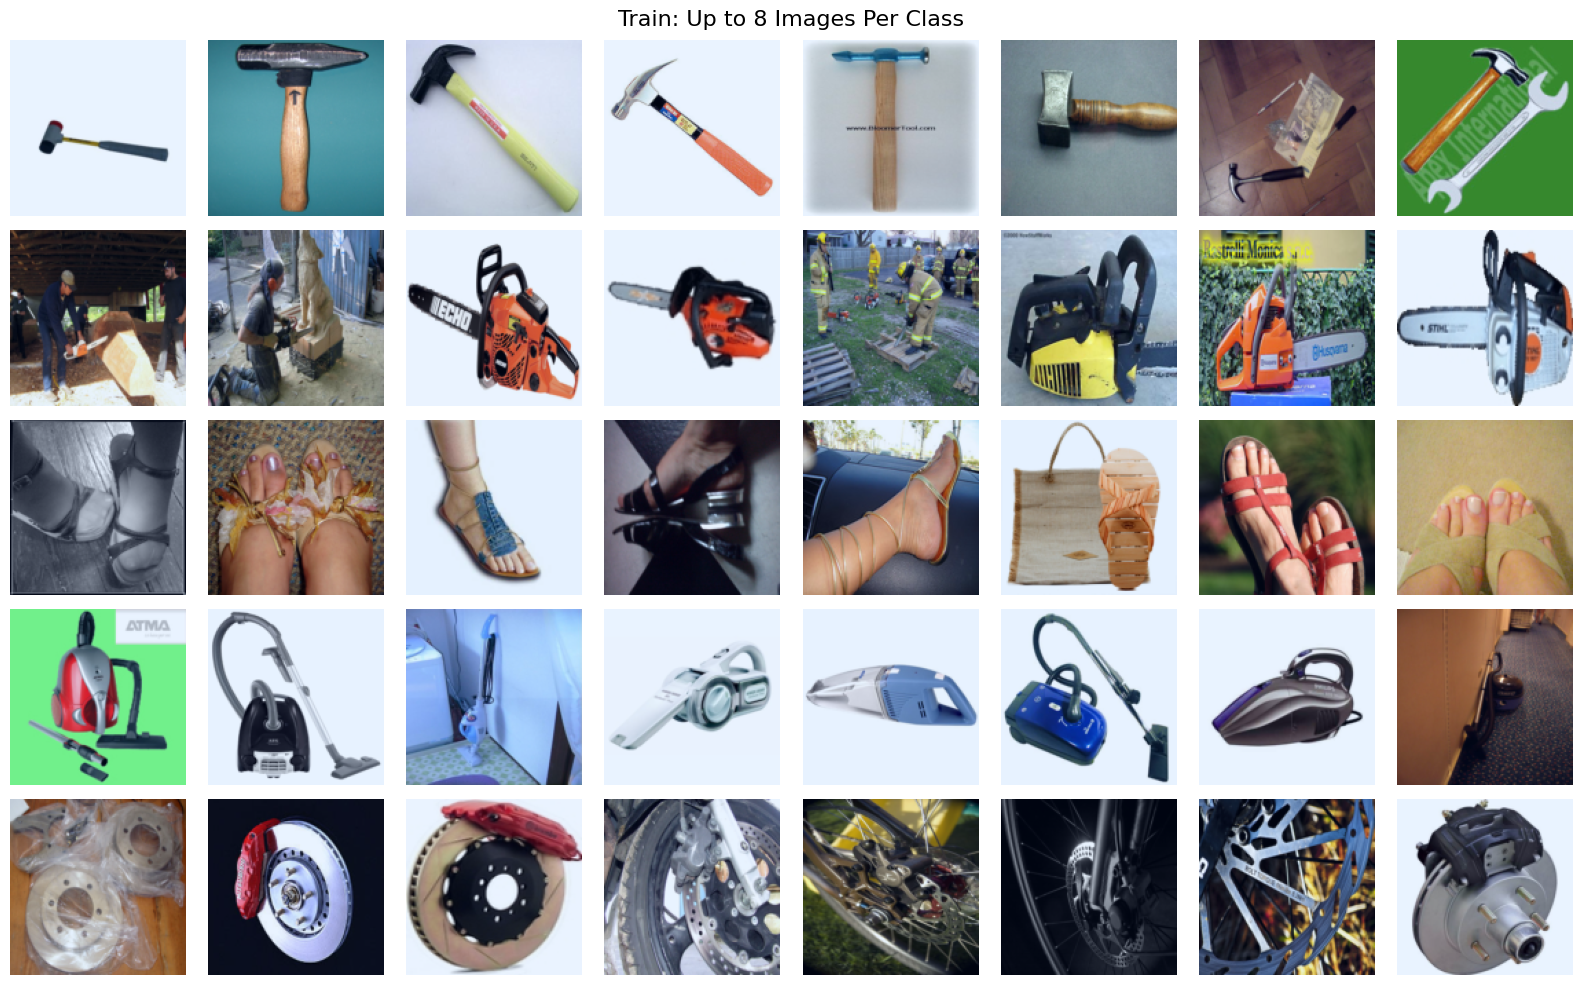

Class counts in Train dataset:


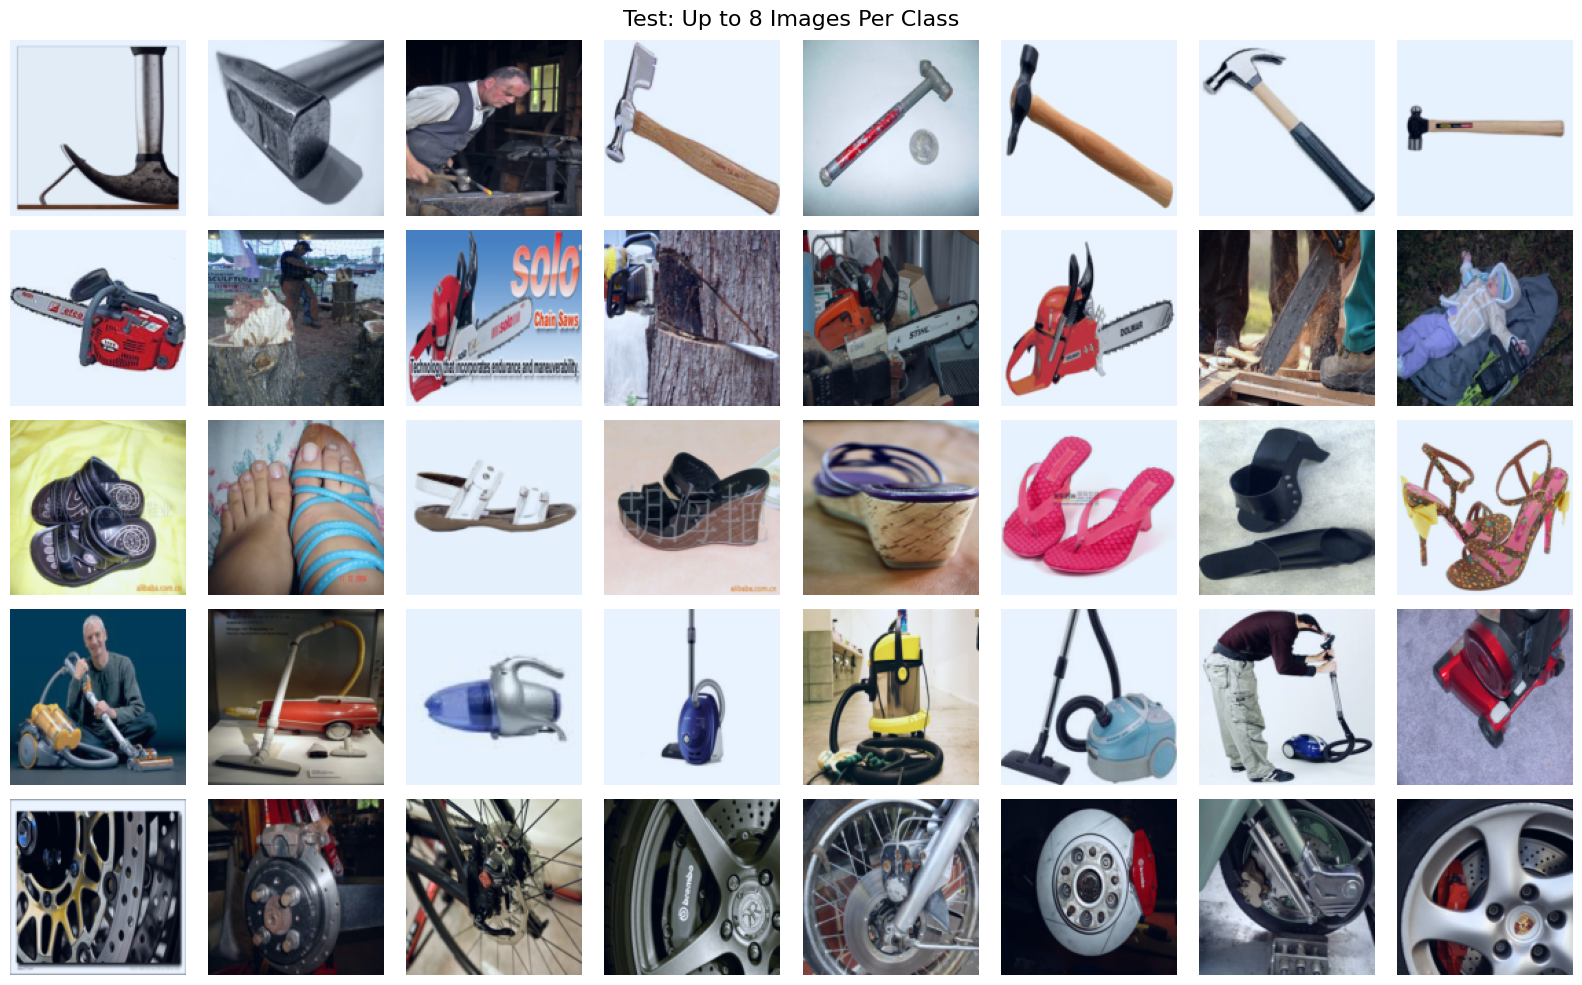

Class counts in Test dataset:
Class counts in Train dataset:
Dataset Train Class 0: 1258 images
Dataset Train Class 1: 1360 images
Dataset Train Class 2: 1240 images
Dataset Train Class 3: 1482 images
Dataset Train Class 4: 1037 images
Class counts in Test dataset:
Dataset Test Class 0: 132 images
Dataset Test Class 1: 159 images
Dataset Test Class 2: 142 images
Dataset Test Class 3: 162 images
Dataset Test Class 4: 114 images


In [72]:

train_data_path_128 = f"{gBase_path}/train_data_128.pth"
test_data_path_128 = f"{gBase_path}/test_data_128.pth"
train_dataloader, test_dataloader = load_data(train_data_path_128, test_data_path_128)
# Display for train dataset
display_images_with_labels(train_dataloader, dataset_name="Train")
display_images_with_labels(test_dataloader, dataset_name="Test")
count_classes(train_dataloader, dataset_name="Train")
count_classes(test_dataloader, dataset_name="Test")

In [104]:
model, optimizer, criterion = get_models(gModel_name[1], gOptimizer_name, gCriterion_name)
train_dataloader, test_dataloader = load_data(train_data_path, test_data_path)
progress = ToolPlot(model, criterion, device, train_dataloader, test_dataloader,1)
es = EarlyStopping()
print("training begin")
for epoch in range(gnEpochs):
        model.train()
        progress.init_running_loss()

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device) # move data to GPU/CPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            progress.add_loss(loss.item())
        
        if es.isStop(progress.append(epoch)):
            break
progress.plot()
save_model(model)
del model
torch.cuda.empty_cache()



model is resnet
Model parameters: 2776389
ModelTotal layers: 8
{172: 0, 684: 1, 789: 2, 823: 3, 938: 4}
Min pixel value: 0.0
Max pixel value: 1.0
Data is already in [0, 1]. Skipping /255.
Computed Mean: [0.6, 0.57, 0.541], Computed Std: [0.312, 0.317, 0.332]
training begin
Epoch 1, Train Loss: 1.5803, Validation Loss: 1.4635, Validation Accuracy: 0.4203
Epoch 2, Train Loss: 1.4017, Validation Loss: 1.3132, Validation Accuracy: 0.5092
Epoch 3, Train Loss: 1.3000, Validation Loss: 1.3313, Validation Accuracy: 0.4683
Epoch 4, Train Loss: 1.2072, Validation Loss: 1.2109, Validation Accuracy: 0.5501


KeyboardInterrupt: 